<a href="https://colab.research.google.com/github/raj26000/Python-and-Machine-Learning/blob/main/RandomForest_Regression_AV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Required Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
train_path = '/content/drive/MyDrive/train_v9rqX0R.csv'
test_path = '/content/drive/MyDrive/test_AbJTz2l.csv'

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136
8521,FDN46,7.210,Regular,0.145221,Snack Foods,103.1332,OUT018,2009,Medium,Tier 3,Supermarket Type2,1845.5976


# Data Preprocessing and Visualization (EDA)

In [4]:
#Handling missing values in data.
print(train_data.isnull().sum())
print(test_data.isnull().sum())

#Imputing missing item weights using already given ones for the same product, hence not taking mean, median.
train_item_weights = {}
for i in range(train_data.shape[0]):
  if train_data.iloc[i,0] not in train_item_weights.keys():
    train_item_weights[train_data.iloc[i,0]] = train_data.iloc[i,1]

for i in range(train_data.shape[0]):
  if np.isnan(train_data.iloc[i,1]):
    train_data.iloc[i,1] = train_item_weights[train_data.iloc[i,0]]

test_item_weights = {}
for i in range(test_data.shape[0]):
  if test_data.iloc[i,0] not in test_item_weights.keys():
    test_item_weights[test_data.iloc[i,0]] = test_data.iloc[i,1]
for i in range(test_data.shape[0]):
  if np.isnan(test_data.iloc[i,1]):
    test_data.iloc[i,1] = test_item_weights[test_data.iloc[i,0]]

train_data['Item_Weight'].fillna(train_data['Item_Weight'].mean(), inplace=True)
test_data['Item_Weight'].fillna(test_data['Item_Weight'].mean(), inplace=True)



Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64
Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64


Low_Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64


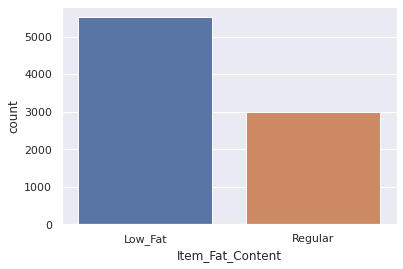

In [5]:
#Eliminating redundant labels in categorical feature
sns.set_theme()
low_fat = ['Low Fat', 'LF', 'low fat']
reg = ['Regular', 'reg']
for i in range(train_data.shape[0]):
  if train_data.iloc[i,2] in low_fat:
    train_data.iloc[i,2] = 'Low_Fat'
  else:
    train_data.iloc[i,2] = 'Regular'

for i in range(test_data.shape[0]):
  if test_data.iloc[i,2] in low_fat:
    test_data.iloc[i,2] = 'Low_Fat'
  else:
    test_data.iloc[i,2] = 'Regular'
print(train_data['Item_Fat_Content'].value_counts())
#Countplot Visualization
sns.countplot(x = train_data['Item_Fat_Content'])

[Text(0, 0, 'Dairy'),
 Text(0, 0, 'Soft Drinks'),
 Text(0, 0, 'Meat'),
 Text(0, 0, 'Fruits and Vegetables'),
 Text(0, 0, 'Household'),
 Text(0, 0, 'Baking Goods'),
 Text(0, 0, 'Snack Foods'),
 Text(0, 0, 'Frozen Foods'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Health and Hygiene'),
 Text(0, 0, 'Hard Drinks'),
 Text(0, 0, 'Canned'),
 Text(0, 0, 'Breads'),
 Text(0, 0, 'Starchy Foods'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Seafood')]

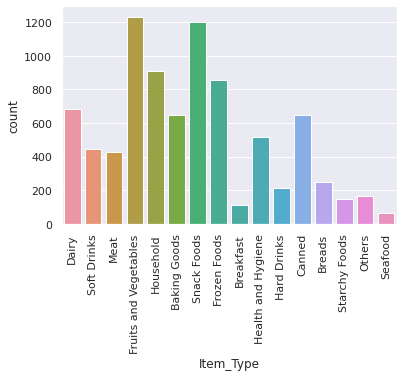

In [6]:
ax = sns.countplot(x = train_data['Item_Type'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

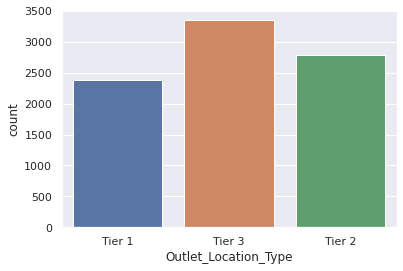

In [7]:
sns.countplot(x = train_data['Outlet_Location_Type'])

[Text(0, 0, 'Supermarket Type1'),
 Text(0, 0, 'Supermarket Type2'),
 Text(0, 0, 'Grocery Store'),
 Text(0, 0, 'Supermarket Type3')]

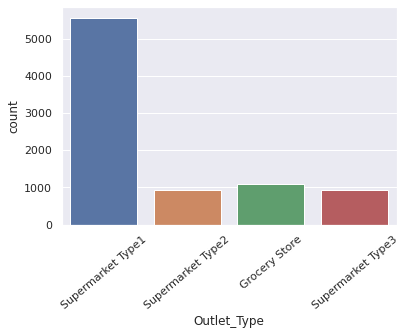

In [8]:
ax = sns.countplot(x = train_data['Outlet_Type'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

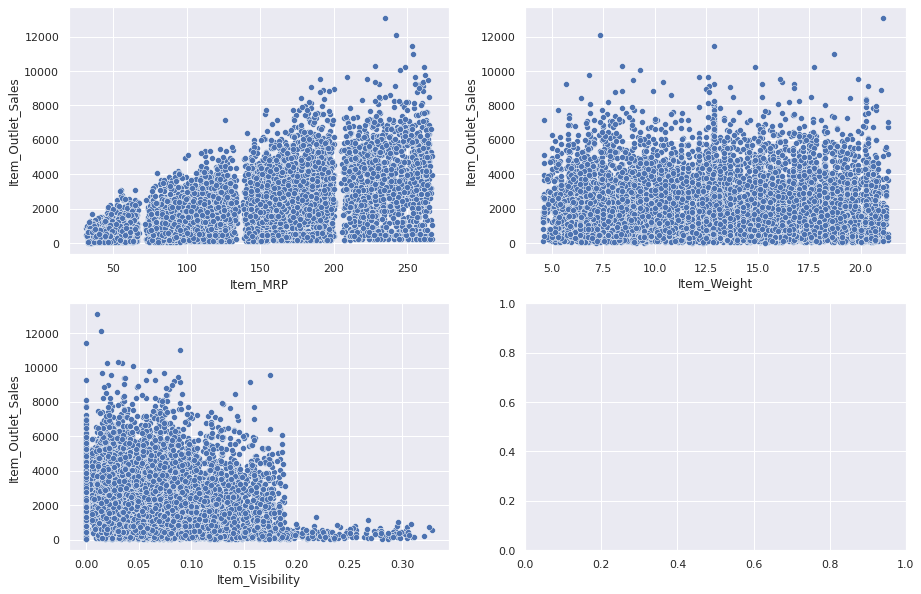

In [9]:
#Scatterplots of numerical variables wrt target numerical variable
numerical = ['Item_MRP', 'Item_Weight', 'Item_Visibility']
fig, ax = plt.subplots(2,2, figsize=(15, 10))
for var, subplot in zip(numerical, ax.flatten()):
    sns.scatterplot(x=var, y='Item_Outlet_Sales', data=train_data, ax=subplot)

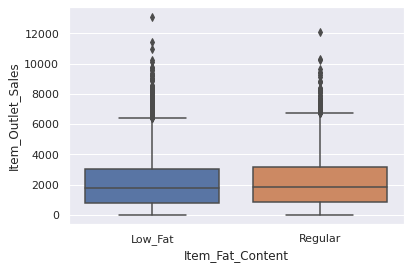

In [10]:
#Boxplots to illustrate relation between categorical features and target numerical variable
sns.boxplot(x = train_data['Item_Fat_Content'], y = train_data['Item_Outlet_Sales'])

[Text(0, 0, 'Dairy'),
 Text(0, 0, 'Soft Drinks'),
 Text(0, 0, 'Meat'),
 Text(0, 0, 'Fruits and Vegetables'),
 Text(0, 0, 'Household'),
 Text(0, 0, 'Baking Goods'),
 Text(0, 0, 'Snack Foods'),
 Text(0, 0, 'Frozen Foods'),
 Text(0, 0, 'Breakfast'),
 Text(0, 0, 'Health and Hygiene'),
 Text(0, 0, 'Hard Drinks'),
 Text(0, 0, 'Canned'),
 Text(0, 0, 'Breads'),
 Text(0, 0, 'Starchy Foods'),
 Text(0, 0, 'Others'),
 Text(0, 0, 'Seafood')]

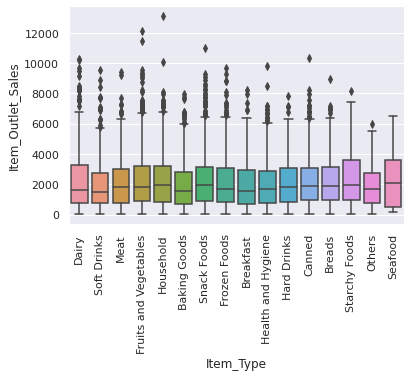

In [11]:
ax = sns.boxplot(x = train_data['Item_Type'], y = train_data['Item_Outlet_Sales'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'Supermarket Type1'),
 Text(0, 0, 'Supermarket Type2'),
 Text(0, 0, 'Grocery Store'),
 Text(0, 0, 'Supermarket Type3')]

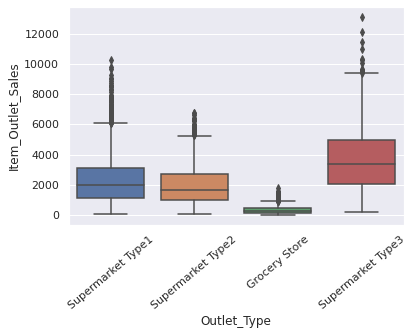

In [12]:
ax = sns.boxplot(x = train_data['Outlet_Type'], y = train_data['Item_Outlet_Sales'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40)

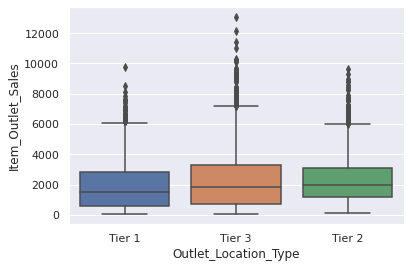

In [13]:
sns.boxplot(x = train_data['Outlet_Location_Type'], y = train_data['Item_Outlet_Sales'])

In [14]:
#Feature scaling for numerical features and generating train and test data
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = train_data['Item_Outlet_Sales']
for col in numerical:
  X_train[col] = train_data[col]
  X_test[col] = test_data[col]

scaler = MinMaxScaler()
train_sc = scaler.fit_transform(X_train)
test_sc = scaler.transform(X_test)

X_train = pd.DataFrame(data = train_sc, columns=numerical)
X_test = pd.DataFrame(data = test_sc, columns=numerical)

#Label encoding for binary and ordinal categorical features
encoder = LabelEncoder()
X_train['Item_Fat_Content'] = encoder.fit_transform(train_data['Item_Fat_Content'])
X_test['Item_Fat_Content'] = encoder.fit_transform(test_data['Item_Fat_Content'])
X_train['Outlet_Location_Type'] = encoder.fit_transform(train_data['Outlet_Location_Type'])
X_test['Outlet_Location_Type'] = encoder.fit_transform(test_data['Outlet_Location_Type'])

#Dummy encoding for non-binary, nominal categorical features
X_train['Item_Type'] = train_data['Item_Type']
X_train['Outlet_Type'] = train_data['Outlet_Type']
X_test['Item_Type'] = test_data['Item_Type']
X_test['Outlet_Type'] = test_data['Outlet_Type']
X_train = pd.get_dummies(X_train, prefix = ['Outlet_Type', 'Item_Type'], columns=['Outlet_Type', 'Item_Type'])
X_test = pd.get_dummies(X_test, prefix = ['Outlet_Type', 'Item_Type'], columns=['Outlet_Type', 'Item_Type'])

# Model Training

In [16]:
#Training the model with GridSearch cross-validation.
model = RandomForestRegressor()
param_grid = {'n_estimators':[200,300,400], 'max_depth':[20,30,None], 'min_samples_leaf':[1,2,3]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=make_scorer(mean_squared_error))
cv_res = grid.fit(X_train, y_train)
print(cv_res.cv_results_)
print(cv_res.best_params_)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'mean_fit_time': array([12.5886807 , 15.6967916 , 20.62761722,  8.96867466, 13.45278006,
       17.81088076,  8.24423299, 12.41692882, 16.50178423, 11.09047813,
       16.73216877, 22.17246728,  9.16578989, 13.7450119 , 18.38520446,
        8.31312346, 12.42917442, 16.55279384, 11.02770286, 16.59978967,
       22.33013406,  9.24024339, 13.87277436, 18.45420775,  8.38247275,
       12.61471701, 16.54141541]), 'std_fit_time': array([2.56905466, 0.21672829, 0.10671522, 0.05233345, 0.07026784,
       0.06472998, 0.0134633 , 0.08009314, 0.09634558, 0.05758985,
       0.07599612, 0.13739235, 0.1059661 , 0.03593743, 0.13678732,
       0.0251283 , 0.04390751, 0.08323724, 0.06087307, 0.12928116,
       0.20529208, 0.05196883, 0.08822612, 0.10433868, 0.04703863,
       0.07299326, 0.62229648]), 'mean_score_time': array([0.19361672, 0.22691069, 0.30377693, 0.12206607, 0.17689734,
       0.23441987, 0.11142316, 0.16201081, 0.21458664, 0.17154427,
       0.25172443, 0.32881746, 0.12555299, 0.19068

In [54]:
#Using CV results or otherwise, generate predictions on test data
#best_model = cv_res.best_estimator_
best_model = RandomForestRegressor(n_estimators=700, max_depth=30, min_samples_leaf=5)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

df = pd.DataFrame()
df['Item_Identifier'] = test_data['Item_Identifier']
df['Outlet_Identifier'] = test_data['Outlet_Identifier']
df['Item_Outlet_Sales'] = y_pred
df.to_csv('RF.csv', index=False)
files.download('RF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>